# Information Retrieval 2022/23

## A Tutorial on Hidden Markov Models and Conditional Random Fields in Python, with an application to utterance-level conversation classification

#### What do we mean by _utterance-level conversation classification_? And how can HMMs/CRFs help in this task? 

Every conversation is a sequence of utterances emitted by two or more people. In the context of a conversation each utterance has a specific role: it might be a question, a reply, an invitation, an order, and so on and so on. These **intentional semantic roles** are instances of hidden states, since utterances are not usually introduced by statements such as ''this is a question:'' or ''this is a reply:''.

Since conversations can be naturally represented as sequences and we have vector space models at our disposal to represent utterances in a numeric form, HMMs and CRFs are natural candidates to predict such hidden roles.


## Outline:
1. The AnnoMI dataset
2. Feature Extraction with TF-IDF
3. Hidden Markov Model with `hmmlearn` library
4. Conditional Random Field with `pycrfsuite` library

## 1. The AnnoMI dataset

AnnoMI [Wu et al - 2022, https://github.com/uccollab/annomi] is a recent dataset containing 133 counselling dialogues annotated by an expert in psychology at the utterance level. It is not part of the ''star system'' of NLP corpora, such as CoNLL or GLUE datasets, but it's interesting for our purpose.

In [1]:
!git clone https://github.com/uccollab/AnnoMI.git

fatal: destination path 'AnnoMI' already exists and is not an empty directory.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("AnnoMI/dataset.csv")
dataset.head()

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form t...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You dri...",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks whe...,therapist_input,NaN


In [4]:
# How does a conversation look like?
for i in range(5):
    print(dataset['interlocutor'].iloc[i].upper())
    print(dataset['utterance_text'].iloc[i], "\n")

THERAPIST
Thanks for filling it out. We give this form to everyone once a year regardless of why they come in. It helps us provide better care. Is it okay if I take a look at what you put down? 

CLIENT
Sure. 

THERAPIST
So, let's see. It looks that you put-- You drink alcohol at least four times a week on average- 

CLIENT
Mm-hmm. 

THERAPIST
-and you usually have three to four drinks when you do drink. 



Every conversation consists of two people (a therapist and a client) whose utterancees can take different roles:
- **therapist behaviour**: question, therapist_input, reflection, other;
- **client talk**: neutral, change, sustain.

Since every utterance is either emitted by the therapist or by the client, we can merge the two to have unique sequences of utterances.

In [5]:
# Merge therapist utterances and client utterances
dataset['label'] = dataset.apply(lambda row: row['main_therapist_behaviour'] if row['interlocutor'] == "therapist" else row['client_talk_type'], axis = 1)

In [6]:
# State set
S = dataset['label'].unique()
S

array(['question', 'neutral', 'therapist_input', 'reflection', 'change',
       'other', 'sustain'], dtype=object)

In [7]:
# How does a conversation look like, with ground truth labels?
for i in range(5):
    print(dataset['interlocutor'].iloc[i].upper(), "-", dataset['label'].iloc[i])
    print(dataset['utterance_text'].iloc[i], "\n")

THERAPIST - question
Thanks for filling it out. We give this form to everyone once a year regardless of why they come in. It helps us provide better care. Is it okay if I take a look at what you put down? 

CLIENT - neutral
Sure. 

THERAPIST - therapist_input
So, let's see. It looks that you put-- You drink alcohol at least four times a week on average- 

CLIENT - neutral
Mm-hmm. 

THERAPIST - therapist_input
-and you usually have three to four drinks when you do drink. 



## 2. Feature Extraction

Besides hidden states, we need observations in the form of either categorical symbols, numeric scalars or vectors. If we were operating at the word-level or at the character-level, using categorical symbols could be appropriate, as both cases involve a limited number of symbols. At the sentence or utterance level, things get trickier, since there are infinitely many possible combinations of words we must account for. 

But vector space models come at rescue. By mapping text in a vector space, the vectors can be used as (multivariate) observations.  

In [8]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [9]:
# Tokenization and stemming
def tokenize_and_stem(s, stemmer = SnowballStemmer("english")):
    
    return [stemmer.stem(s) for s in word_tokenize(s)]

In [10]:
# TF-IDF
tfidf = TfidfVectorizer(norm = None, max_features = 1000, tokenizer = tokenize_and_stem, stop_words = "english")
X = tfidf.fit_transform(dataset['utterance_text'])

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [11]:
X.shape

(9699, 1000)

In [12]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

## 3. Hidden Markov Model with `hmmlearn` library

Once upon a time, `sklearn` had a module for HMMs. Unfortunately, it is not maintained anymore. Other flexible enough libraries for this task are `hmmlearn` and `pomegranate`. For HMMs with categorical symbols only, `nltk` provides its own implementation, which includes unsupervised and supervised training.

Empirical distributions of TF-IDF scores have been observed to approximate a normal, lognormal or Zipf law depending on the case. Simplification step: assume normality of observations so to apply a HMM model with Gaussian emissions.

In [13]:
# !pip install hmmlearn
from hmmlearn.hmm import GaussianHMM
from collections import Counter

In [14]:
# Initialize model
model = GaussianHMM(n_components = len(S), covariance_type = "diag", tol = 1e-4, random_state = 42, verbose = True)

In [15]:
# Get sequence lengths to let the model separate different dialogues
seq_lengths = dataset['transcript_id'].value_counts().sort_index()

In [16]:
# Training (Baum-Welch algorithm)
model.fit(X_scaled, seq_lengths.values)

         1 -13727845.55657868             +nan
         2  554350.80274138 +14282196.35932007
         3 12617432.71874190 +12063081.91600052
         4 14178650.50613838 +1561217.78739648
         5 14353006.51493734 +174356.00879897
         6 14387372.12146613  +34365.60652879
         7 14410870.85146410  +23498.72999797
         8 14412355.01640713   +1484.16494303
         9 14412355.01640797      +0.00000085


GaussianHMM(n_components=7, random_state=42, tol=0.0001, verbose=True)

<AxesSubplot:>

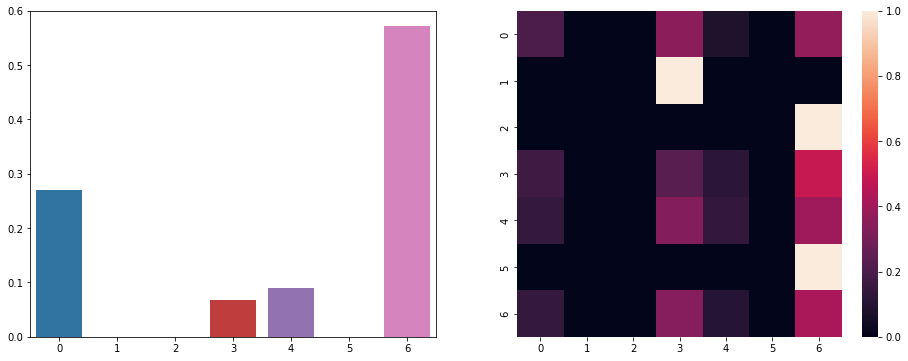

In [17]:
# How are starting probabailities and transition probabilities distributed?
f, ax = plt.subplots(1,2, figsize = (16,6))
sns.barplot(x = list(range(len(model.startprob_))), y = model.startprob_, ax = ax[0])
sns.heatmap(model.transmat_, ax = ax[1])

One issue with HMMs is that they will never predict exactly the labels we want, since their unsupervised nature gives them no clue about what these labels mean, just like in clustering. The other big issue is that some states may be unreachable or almost unreachable.

Here is an example:

In [18]:
i = 2
example = dataset.loc[dataset['transcript_id'] == i, ['utterance_text', 'label']]
example['predicted_state'] = model.decode(X_scaled[:seq_lengths[i], :])[-1]

example

,utterance_text,label,predicted_state
91,"Hi, John. Nice to see you again. So, tell me, ...",question,6
92,"Well, doc, I know you told me that I need to l...",neutral,6
93,"Well, I appreciate you bringing your weight to...",question,4
94,"No, by all means. I know we have to discuss it.",neutral,3
95,"All right. Uh, well, it sounds like you've bee...",reflection,6
96,I started watching what I ate and I ate less. ...,change,6
97,But you did have some success. Tell me how you...,reflection,6
98,I felt great and I felt really proud of myself...,change,3
99,"Okay. Well, it sounds like you realized that w...",reflection,0
100,"Well, I think it's because I've been eating mo...",sustain,3


In [19]:
# Predict all states for all conversations
dataset['predicted_state'] = model.decode(X_scaled, seq_lengths.values)[-1]

In [20]:
# Look at correspondences between ground truth labels and predicted hidden states
correspondences = dataset.groupby("predicted_state").agg(list)['label']
correspondences.apply(Counter).apply(lambda c: c.most_common()[:3])

predicted_state
0    [(neutral, 317), (reflection, 286), (therapist...
1                               [(therapist_input, 1)]
2                                       [(neutral, 1)]
3    [(neutral, 1153), (other, 1061), (question, 245)]
4     [(neutral, 375), (question, 163), (change, 156)]
5                                        [(change, 1)]
6    [(neutral, 1256), (question, 750), (reflection...
Name: label, dtype: object

#### How to evaluate it?

Use clustering metrics.

In [25]:
from sklearn.metrics import rand_score, homogeneity_score, completeness_score
from scipy.stats import hmean

In [58]:
# RAND score is a proxy to accuracy
RAND = rand_score(dataset['label'], dataset['predicted_state'])
RAND

0.6332479567333938

In [59]:
# Completeness is a proxy to recall (measures how many points of the same class are actually in the same predicted cluster)
COMP = completeness_score(dataset['label'], dataset['predicted_state'])
COMP

0.08660849550747556

In [60]:
# Homogeneity is a proxy to precision (measures how many points of the same predicted cluster are actually in the same class)
HOMO = homogeneity_score(dataset['label'], dataset['predicted_state'])
HOMO

0.060498902415991214

In [29]:
# F1 score
F = hmean([COMP, HOMO])
F

0.07123664740271679

## 4. Conditional Random Field with `pycrfsuite` library

Library `pycrfsuite`, documentation here:

https://python-crfsuite.readthedocs.io/en/latest/pycrfsuite.html#api-reference

And here:

https://www.chokkan.org/software/crfsuite/manual.html#idp8849121424

Since CRFs are supervised models, we must first split our dataset into a training and a test set. Then we can train the model and evaluate it using classification metrics (Precision, Recall, Accuracy, F1).

In [30]:
#!pip install python-crfsuite
import pycrfsuite
from sklearn.model_selection import train_test_split

In [31]:
# PyCRFsuite has the peculiarity of needing lists of dictionaries as inputs
dataset['vector'] = X.toarray().tolist()
tfidf_features = tfidf.get_feature_names_out()

dataset['features'] = dataset['vector'].apply(lambda v: {k:a for k,a in zip(tfidf_features, v)})
grouped_data = dataset.groupby("transcript_id").agg(list)

In [62]:
dataset['features'][0]

{'$': 0.0,
 '%': 0.0,
 "'": 0.0,
 "''": 0.0,
 "'d": 0.0,
 "'m": 0.0,
 "'s": 0.0,
 ',': 0.0,
 '-': 0.0,
 '--': 0.0,
 '-and': 0.0,
 '-becaus': 0.0,
 '-but': 0.0,
 '-for': 0.0,
 '-i': 0.0,
 '-if': 0.0,
 '-it': 0.0,
 '-or': 0.0,
 '-so': 0.0,
 '-that': 0.0,
 '-the': 0.0,
 '-to': 0.0,
 '-um': 0.0,
 '-what': 0.0,
 '-you': 0.0,
 '.': 3.549687555176238,
 '0': 0.0,
 '1': 0.0,
 '10': 0.0,
 '100': 0.0,
 '12': 0.0,
 '20': 0.0,
 '25': 0.0,
 '30': 0.0,
 '40': 0.0,
 '5': 0.0,
 '?': 2.5557505788301844,
 '[': 0.0,
 ']': 0.0,
 '``': 0.0,
 'a-': 0.0,
 'a-a': 0.0,
 'abl': 0.0,
 'about-': 0.0,
 'absolut': 0.0,
 'accept': 0.0,
 'accid': 0.0,
 'achiev': 0.0,
 'act': 0.0,
 'action': 0.0,
 'activ': 0.0,
 'actual': 0.0,
 'ad': 0.0,
 'addict': 0.0,
 'adult': 0.0,
 'affect': 0.0,
 'afford': 0.0,
 'age': 0.0,
 'ago': 0.0,
 'agre': 0.0,
 'ah': 0.0,
 'ahead': 0.0,
 'alcohol': 0.0,
 'allow': 0.0,
 'alon': 0.0,
 'alreadi': 0.0,
 'alright': 0.0,
 'alway': 0.0,
 'and-': 0.0,
 'and-and': 0.0,
 'and-and-and': 0.0,
 'and—':

In [32]:
# Splitting training and test sets
X_train, X_test, y_train, y_test = train_test_split(grouped_data['features'], grouped_data['label'], test_size = 0.2, random_state = 24)

In [33]:
# Model initialization
crf = pycrfsuite.Trainer(verbose = False)

crf.set_params({
    'c1': 1e-4,
    'c2': 1.0,
    'max_iterations': 100,
    'feature.minfreq': 0.0,
    'feature.possible_states': False,
    'feature.possible_transitions': False
})
# 'c1', 'c2', 'max_iterations' are parameters of the training algorithm (LBFGS in this case)
# 'minfreq', 'possible_states', 'possible_transitions' are parameters of the model (linear-chain first-order CRF)

for xseq, yseq in zip(X_train, y_train):
    crf.append(xseq, yseq)

In [34]:
# Train and save model
crf.train("example-annomi.crfsuite")

In [35]:
crftagger = pycrfsuite.Tagger()
crftagger.open('example-annomi.crfsuite')

In [36]:
# Model in action
random_idx = np.random.choice(X_test.index)
predicted = crftagger.tag(X_test[random_idx])

In [45]:
crf_example = [{'True': y_true, "Pred": y_pred} for y_true, y_pred in zip(y_test[random_idx], predicted)]
pd.DataFrame.from_records(crf_example)

,True,Pred
0,other,question
1,neutral,neutral
2,question,question
3,change,sustain
4,reflection,reflection
5,sustain,change
6,therapist_input,therapist_input
7,neutral,neutral
8,therapist_input,reflection
9,sustain,change


#### Evaluation

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [47]:
predictions = X_test.apply(crftagger.tag)

In [48]:
print(classification_report(y_test.explode(), predictions.explode()))

                 precision    recall  f1-score   support

         change       0.46      0.31      0.37       181
        neutral       0.62      0.75      0.68       373
          other       0.66      0.75      0.70       212
       question       0.73      0.68      0.70       205
     reflection       0.33      0.39      0.36       127
        sustain       0.30      0.21      0.24        86
therapist_input       0.41      0.30      0.35       119

       accuracy                           0.56      1303
      macro avg       0.50      0.48      0.49      1303
   weighted avg       0.55      0.56      0.55      1303



(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'question'),
  Text(1, 0, 'neutral'),
  Text(2, 0, 'therapist_input'),
  Text(3, 0, 'other'),
  Text(4, 0, 'change'),
  Text(5, 0, 'reflection'),
  Text(6, 0, 'sustain')])

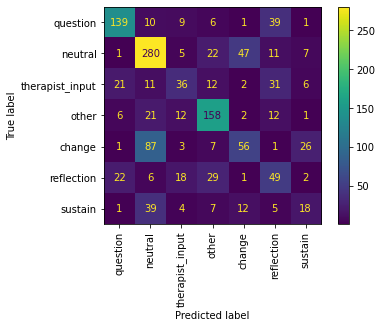

In [49]:
cm = confusion_matrix(y_test.explode(), predictions.explode(), labels = crftagger.labels())
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = crftagger.labels()).plot()
plt.xticks(rotation = 90)

#### Explain

Besides performing better than the HMM model, the CRF model is also inherently **explainable**. The concept of explainability is a little more complex than this, but for the moment being we may reduce it to the search of the features that contribute to predict a certain label or not. Transitions between states can also be analyzed.

In [50]:
info = crftagger.info()

In [51]:
# Find the 10 highest coefficients of features predicting labels
feat_label_coeff = sorted(info.state_features.items(), key = lambda tup: tup[1], reverse = True)
feat_label_coeff[:10]

[(('?', 'question'), 1.492878),
 (('tell', 'question'), 0.889808),
 (('lose', 'other'), 0.830893),
 (('my-mi', 'other'), 0.812425),
 (('attack', 'neutral'), 0.778479),
 (('particular', 'other'), 0.771666),
 (('cigar', 'sustain'), 0.754808),
 (('routin', 'other'), 0.736254),
 (('driver', 'other'), 0.722189),
 (('role', 'other'), 0.711776)]

In [52]:
feat_label_coeff[-10:]

[(('laugh', 'other'), -0.767974),
 (('person', 'other'), -0.771766),
 (('the-', 'sustain'), -0.787862),
 (('routin', 'sustain'), -0.794845),
 (('improv', 'sustain'), -0.807295),
 (('short', 'change'), -0.814194),
 (('tri', 'other'), -0.853633),
 (('allow', 'change'), -0.878523),
 (('hear', 'change'), -0.927549),
 (('?', 'other'), -0.992582)]

In [53]:
# Now let's analyze transitions
transition_coeff = sorted(info.transitions.items(), key = lambda tup: tup[1], reverse = True)
transition_coeff[:10]

[(('neutral', 'other'), 4.195087),
 (('other', 'neutral'), 3.549955),
 (('change', 'other'), 3.490968),
 (('reflection', 'neutral'), 3.378674),
 (('neutral', 'reflection'), 3.349661),
 (('question', 'neutral'), 2.961864),
 (('sustain', 'other'), 2.753604),
 (('reflection', 'change'), 2.684826),
 (('other', 'change'), 2.680813),
 (('change', 'reflection'), 2.648347)]

In [54]:
transition_coeff[-10:]

[(('sustain', 'sustain'), -0.937075),
 (('change', 'change'), -1.010542),
 (('reflection', 'reflection'), -1.08678),
 (('other', 'reflection'), -1.259734),
 (('therapist_input', 'therapist_input'), -1.378457),
 (('other', 'therapist_input'), -1.420449),
 (('reflection', 'question'), -1.69929),
 (('question', 'question'), -1.856084),
 (('therapist_input', 'question'), -2.022072),
 (('other', 'question'), -2.147856)]

> Note: `pycrfsuite` doesn't support separate state space for random variables in a sequence. This may limit its usage in cases such as the one we addressed, where consecutive variables have different state spaces, but the model should learn null transition probabilities for transitions that are never observed in the data, thus replicating separate state spaces.